<a href="https://colab.research.google.com/github/Vernalhav/image_processing_project/blob/main/PDI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
from scipy import ndimage
from skimage import transform, io

import os

## Porto seguro

In [59]:
def load_dataset_instance(num, return_as_matrix=False):
    imgs = []
    for i in range(5):
        if return_as_matrix: imgs.append([])

        for j in range(5):
            img = cv2.imread(f'/drive/Shareddrives/PDI/Dataset/{num}/seq{num}_{i+1}_{j+1}.jpg')
            if return_as_matrix: imgs[-1].append(img)
            else: imgs.append(img)
    
    return imgs

In [3]:
imgs = []

def main():
    global imgs
    
    if not os.path.exists('/drive'):
        from google.colab import drive
        drive.mount('/drive')
    
    imgs = load_dataset_instance(1)

In [4]:
if __name__ == '__main__':
    main()

Mounted at /drive


## O Retorno do Rei: identificação do grid

In [60]:
from functools import reduce
import operator
import math

def sort_clockwise(points):
    '''
    Returns points sorted in clockwise order starting from the bottom left corner.
    Because image coordinates are flipped, this returns the four corners of the
    rectangle in the following order:
        TOP_LEFT, BOTTOM_LEFT, BOTTOM_RIGHT, TOP_RIGHT
    '''
    center = tuple(map(operator.truediv, reduce(lambda x, y: map(operator.add, x, y), points), [len(points)] * 2))
    return sorted(points, key=lambda coord: (-135 - math.degrees(math.atan2(*tuple(map(operator.sub, coord, center))[::-1]))) % 360)

In [29]:
from skimage.morphology import skeletonize

# CUIDADO! AS COORDENADAS SÃO RETORNADAS NA TROLAGEM DO OPENCV DE TROCAR X E Y!!!!
def find_central_box(img):

    _, grid = cv2.threshold(img, 210, 255, cv2.THRESH_BINARY)

    grid = cv2.cvtColor(grid, cv2.COLOR_BGR2GRAY)

    kernel = cv2.getStructuringElement(cv2.MORPH_DILATE, (3,3))
    morphed = cv2.morphologyEx(grid, cv2.MORPH_DILATE, kernel, iterations=50)
    kernel = cv2.getStructuringElement(cv2.MORPH_OPEN, (5,5))
    eroded = cv2.morphologyEx(morphed, cv2.MORPH_OPEN, kernel, iterations=35)
    eroded[eroded > 0] = 1
    eroded[eroded <= 0] = 0

    # perform skeletonization
    skeleton = skeletonize(eroded).astype(np.uint8)

    # fill the central region
    flood = cv2.floodFill(skeleton, None, (int(img.shape[0]/2), int(img.shape[1]/2)), newVal = (255,255,255))[1]
    _, flood = cv2.threshold(flood, 210, 255, cv2.THRESH_BINARY)

    cnts = cv2.findContours(flood, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    min_area = 100
    max_area = np.inf

    if len(cnts) > 1:
        print("WARNING: Mais de um contorno encontrado.")

    rect = cv2.minAreaRect(cnts[0])
    box = cv2.boxPoints(rect)
    box = np.int0(box)

    return sort_clockwise(box)

In [67]:
from enum import Enum, auto

class MatchMode(Enum):
    Horizontal = auto()
    Vertical = auto()


def get_transform(corner_coordsA, corner_coordsB, direction=MatchMode.Horizontal):
    '''
    Returns the transformation matrix that takes the relevant points
    in corner_coordsB and maps them to the relevant points in corner_coordsA

    A = Matrix * B
    '''
    topLeftA, botLeftA, botRightA, topRightA = corner_coordsA
    topLeftB, botLeftB, botRightB, topRightB = corner_coordsB

    source, dest = None, None
    if direction == MatchMode.Horizontal:
        source = np.array([topLeftB, botLeftB])
        dest = np.array([topRightA, botRightA])
    
    if direction == MatchMode.Vertical:
        source = np.array([topLeftB, topRightB])
        dest = np.array([botLeftA, botRightA])

    M = transform.estimate_transform('euclidean', source, dest)
    return M.params

In [62]:
imageA = imgs[0]
imageB = imgs[5]

coordsA = find_central_box(imageA)
coordsB = find_central_box(imageB)

In [68]:
M_params = get_transform(coordsA, coordsB, MatchMode.Vertical)

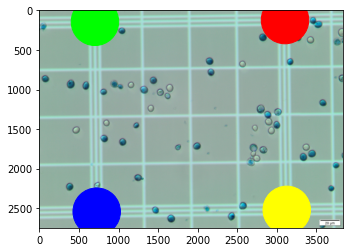

In [63]:
from matplotlib.patches import Circle

fig, ax = plt.subplots()
ax.imshow(imageA)
TOP_RIGHT  = (1, 0, 0)
TOP_LEFT   = (0, 1, 0)
BOT_LEFT   = (0, 0, 1)
BOT_RIGHT  = (1, 1, 0)

topLeftA, botLeftA, botRightA, topRightA = coordsA
ax.add_patch(Circle(botLeftA, 300, color=BOT_LEFT))
ax.add_patch(Circle(botRightA, 300, color=BOT_RIGHT))
ax.add_patch(Circle(topLeftA, 300, color=TOP_LEFT))
ax.add_patch(Circle(topRightA, 300, color=TOP_RIGHT))

In [69]:
M_params

array([[ 9.99987494e-01, -5.00114498e-03,  1.17615354e+02],
       [ 5.00114498e-03,  9.99987494e-01,  2.30496316e+03],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

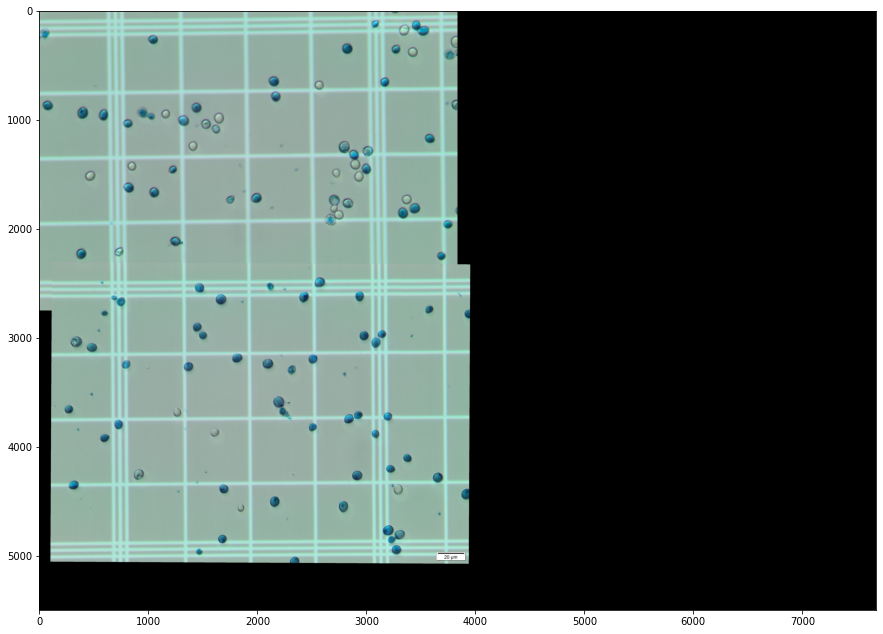

In [75]:
final_img = np.zeros((2*imageA.shape[0], 2*imageA.shape[1], imageA.shape[2]), dtype=np.uint8)
final_img[:imageA.shape[0], :imageA.shape[1], :] = imageA

plt.figure(figsize=(15, 15))
cv2.warpAffine(imageB, M_params[:2, :], (final_img.shape[1], final_img.shape[0]), dst=final_img, borderMode=cv2.BORDER_TRANSPARENT)
plt.imshow(final_img)

## Friendship ended with OpenCV now Skimage is my best friend
Ainda não deu certo time, to tentando refazer o feature matching do OpenCV com o skimage (documentação melhor)

In [ ]:
from skimage import transform, io

In [ ]:
imageA = skimage.color.rgb2gray(imgs[0])
imageB = skimage.color.rgb2gray(imgs[1])

imageA = transform.rescale(imageA, 0.25)
imageB = transform.rescale(imageB, 0.25)

M = transform.EuclideanTransform()
M.estimate(imageB, imageA)
# M = transform.estimate_transform('euclidean', imageB, imageA)

True

## Pré-história

In [ ]:
def lineImage(image):
    #rgba(143,171,159,255) --> background
    #rgba(166,216,213,255) --> line color

    arr = np.copy(image)

    R = [(156,176),(206,226),(203,223)]

    red_range = np.logical_and(R[0][0] < arr[:,:,0], arr[:,:,0] < R[0][1])
    green_range = np.logical_and(R[1][0] < arr[:,:,1], arr[:,:,1] < R[1][1])
    blue_range = np.logical_and(R[2][0] < arr[:,:,2], arr[:,:,2] < R[2][1])
    valid_range = np.logical_and(red_range, green_range, blue_range)

    arr[valid_range] = 200
    arr[np.logical_not(valid_range)] = 0

    return arr
  
@benchmark
def rotateImage(image):
  img_before = lineImage(image)
  img_gray = cv2.cvtColor(img_before, cv2.COLOR_BGR2GRAY)
  img_edges = cv2.Canny(img_gray, 150, 100, apertureSize=3)
 
  lines = cv2.HoughLinesP(img_edges, 1, math.pi / 180.0, 100, minLineLength=100, maxLineGap=5)

  angles = []

  for [[x1, y1, x2, y2]] in lines:
      cv2.line(img_before, (x1, y1), (x2, y2), (255,0,0), 3)
      angle = math.degrees(math.atan2(y2 - y1, x2 - x1))
      if abs(angle) < 10:
        angles.append(angle)

  median_angle = np.median(angles)
  print(f"Angle is {median_angle:.04f}")
  return ndimage.rotate(image, median_angle, reshape=False)

In [ ]:
@benchmark
def stitch(imgs):
    stitcher = cv2.Stitcher.create(cv2.Stitcher_SCANS)
    status, pano = stitcher.stitch(imgs)
    return pano

In [ ]:
def downscale(img, scale_percent):
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)

    return cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

In [ ]:
def phase_correlation(image1, image2):
    image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    
    return cv2.phaseCorrelate(np.float32(image1), np.float32(image2))

In [ ]:
def warpPerspectivePadded(
        src, dst, M,
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=0):
    """Performs a perspective warp with padding.
    Parameters
    ----------
    src : array_like
        source image, to be warped.
    dst : array_like
        destination image, to be padded.
    M : array_like
        `3x3` perspective transformation matrix.
    Returns
    -------
    src_warped : ndarray
        padded and warped source image
    dst_padded : ndarray
        padded destination image, same size as src_warped
    Optional Parameters
    -------------------
    flags : int, optional
        combination of interpolation methods (`cv2.INTER_LINEAR` or
        `cv2.INTER_NEAREST`) and the optional flag `cv2.WARP_INVERSE_MAP`,
        that sets `M` as the inverse transformation (`dst` --> `src`).
    borderMode : int, optional
        pixel extrapolation method (`cv2.BORDER_CONSTANT` or
        `cv2.BORDER_REPLICATE`).
    borderValue : numeric, optional
        value used in case of a constant border; by default, it equals 0.
    See Also
    --------
    warpAffinePadded() : for `2x3` affine transformations
    cv2.warpPerspective(), cv2.warpAffine() : original OpenCV functions
    """

    assert M.shape == (3, 3), \
        'Perspective transformation shape should be (3, 3).\n' \
        + 'Use warpAffinePadded() for (2, 3) affine transformations.'

    M = M / M[2, 2]  # ensure a legal homography
    if flags in (cv2.WARP_INVERSE_MAP,
                 cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP,
                 cv2.INTER_NEAREST + cv2.WARP_INVERSE_MAP):
        M = cv2.invert(M)[1]
        flags -= cv2.WARP_INVERSE_MAP

    # it is enough to find where the corners of the image go to find
    # the padding bounds; points in clockwise order from origin
    src_h, src_w = src.shape[:2]
    lin_homg_pts = np.array([
        [0, src_w, src_w, 0],
        [0, 0, src_h, src_h],
        [1, 1, 1, 1]])

    # transform points
    transf_lin_homg_pts = M.dot(lin_homg_pts)
    transf_lin_homg_pts /= transf_lin_homg_pts[2, :]

    # find min and max points
    min_x = np.floor(np.min(transf_lin_homg_pts[0])).astype(int)
    min_y = np.floor(np.min(transf_lin_homg_pts[1])).astype(int)
    max_x = np.ceil(np.max(transf_lin_homg_pts[0])).astype(int)
    max_y = np.ceil(np.max(transf_lin_homg_pts[1])).astype(int)

    # add translation to the transformation matrix to shift to positive values
    anchor_x, anchor_y = 0, 0
    transl_transf = np.eye(3, 3)
    if min_x < 0:
        anchor_x = -min_x
        transl_transf[0, 2] += anchor_x
    if min_y < 0:
        anchor_y = -min_y
        transl_transf[1, 2] += anchor_y
    shifted_transf = transl_transf.dot(M)
    shifted_transf /= shifted_transf[2, 2]

    # create padded destination image
    dst_h, dst_w = dst.shape[:2]

    pad_widths = [anchor_y, max(max_y, dst_h) - dst_h,
                  anchor_x, max(max_x, dst_w) - dst_w]

    dst_padded = cv2.copyMakeBorder(dst, *pad_widths,
                                    borderType=borderMode, value=borderValue)
    
    dst_pad_h, dst_pad_w = dst_padded.shape[:2]
    src_warped = cv2.warpPerspective(
        src, shifted_transf, (dst_pad_w, dst_pad_h),
        flags=flags, borderMode=borderMode, borderValue=borderValue)

    return dst_padded, src_warped

In [ ]:
def convertRectangle(perspective, cmp_img):
    height,width = cmp_img.shape
    rectangles = np.float32([[0,0, 0,width-1, height-1,0, height-1,width-1]]).reshape(1,4,2)
    converted_rectangle = cv2.perspectiveTransform(rectangles,np.linalg.inv(perspective))
    xmax = math.ceil(converted_rectangle[0,:,0].max())
    xmin = math.floor(converted_rectangle[0,:,0].min())
    ymax = math.ceil(converted_rectangle[0,:,1].max())
    ymin = math.floor(converted_rectangle[0,:,1].min())
    return [xmin,ymin,xmax,ymax]

In [ ]:
def stitching(perspective, ref_img, cmp_img):
    xmin,ymin,xmax,ymax = convertRectangle(perspective, cmp_img)
    hei,wid = ref_img.shape
    sxmax = max(xmax,wid-1)
    sxmin = min(xmin,0)
    symax = max(ymax,hei-1)
    symin = min(ymin,0)
    swidth,sheight = sxmax-sxmin+1,symax-symin+1
    xtrans,ytrans = 0-sxmin,0-symin
    Trans = np.float32([1,0,xtrans , 0,1,ytrans, 0,0,1]).reshape(3,3)
    newTrans = np.dot(Trans,np.linalg.inv(perspective))
    warpedimage = cv2.warpPerspective(cmp_img,newTrans,(swidth,sheight),flags=cv2.INTER_LINEAR+cv2.WARP_FILL_OUTLIERS)
    warpedimage[ytrans:ytrans+hei,xtrans:xtrans+wid] = ref_img
    plt.figure()
    plt.imshow(warpedimage,vmin=warpedimage.min(),vmax=warpedimage.max(),cmap='gray')
    plt.show()

In [ ]:
persp, imageA, imageB = get_persp(imgs[0], imgs[1])

In [ ]:
stitching(persp, imageA, imageB)

LinAlgError: ignored

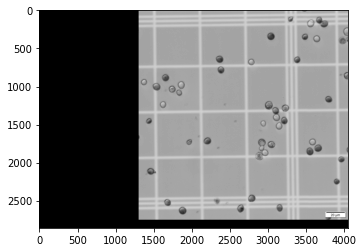

In [ ]:
dst_pad, warped = warpPerspectivePadded(imageB, imageA, persp)
plt.imshow(dst_pad, cmap="gray")

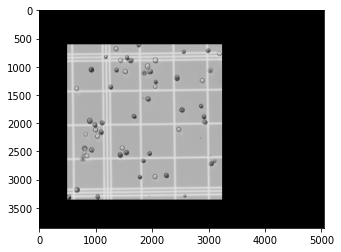

In [ ]:
pad_warp = np.pad(warped, (500, 500), 'constant', constant_values=0)
plt.imshow(pad_warp, cmap="gray")

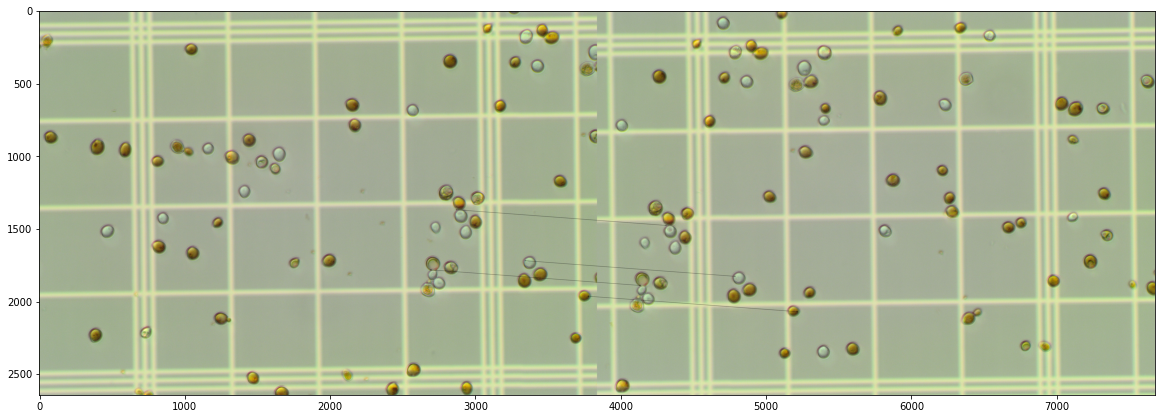

array([[ 9.59596287e-01,  5.29112727e-02, -2.35334855e+03],
       [-1.16010313e-02,  1.01478944e+00,  1.20934888e+02]])

In [ ]:
get_affine_transform_old(imgs[0], imgs[1])

In [ ]:
def get_affine_transform(image1, image2, direction=MatchMode.Horizontal, margin_tolerance=0.4):
    ''' horizontal: image1 - image2
        vertical: image1
                    |
                  image2
    '''

    image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY).reshape((image1.shape[0], image1.shape[1], 1)).reshape(image1.shape[:2])
    image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY).reshape((image2.shape[0], image2.shape[1], 1)).reshape(image2.shape[:2])

    mask1, mask2 = None, None
    if direction == MatchMode.Horizontal:
        mask1 = get_image_mask(image1, Side.Label, margin_tolerance)
        mask2 = get_image_mask(image2, Side.Label, margin_tolerance)

    # if direction == MatchMode.Vertical:
    #     mask1 = get_image_mask(image1, Side.Down, margin_tolerance)
    #     mask2 = get_image_mask(image2, Side.Up, margin_tolerance)

    image1_masked = np.array(image1)
    image1_masked[ mask1 == 0 ] = 0

    image2_masked = np.array(image2)
    image2_masked[ mask2 == 0 ] = 0
    
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 2, 1)
    plt.imshow( image1_masked, cmap='gray' )
    plt.subplot(1, 2, 2)
    plt.imshow( image2_masked, cmap='gray' )
    plt.show()

    orb = cv2.ORB_create(nfeatures=1000)

    print(f'{image1.shape} {mask1.shape}')
    print(f'{image2.shape} {mask2.shape}')

    kp1, des1 = orb.detectAndCompute(image1, mask=mask1)
    kp2, des2 = orb.detectAndCompute(image2, mask=mask2)

    bf = cv2.BFMatcher_create(normType=cv2.NORM_HAMMING)
    matches = bf.knnMatch(des1, des2, k=2)

    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)
    
    print(f'Found {len(good)} good matches')
    good = sorted(good, key = lambda x : x.distance)
    
    plt.figure(figsize=(20,20))
    plt.imshow(cv2.drawMatches(image1, kp1, image2, kp2, good[:4], None, matchColor=(255,0,0)))
    plt.show()

    pts1 = np.zeros((3,2), dtype=np.float32)
    pts2 = np.zeros((3,2), dtype=np.float32)

    for i in range(3):
        print(f'qIdx: {good[i].queryIdx}, tIdx: {good[i].trainIdx}')
        pts1[i] = kp1[good[i].queryIdx].pt
        pts2[i] = kp2[good[i].trainIdx].pt
    
    return cv2.getAffineTransform(pts2, pts1)

NameError: ignored

In [ ]:
imageA = imgs[0]
imageB = imgs[1]

stitcher = cv2.Stitcher.create(cv2.Stitcher_SCANS)
stitcher.estimateTransform()
# M = get_affine_transform(imageA, imageB)

# print(M)
# result = cv2.warpPerspective(imageB, M, (imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
# result[0:imageA.shape[0], 0:imageA.shape[1]] = imageA

# plt.figure(figsize=(20,20))
# plt.imshow(result)

1

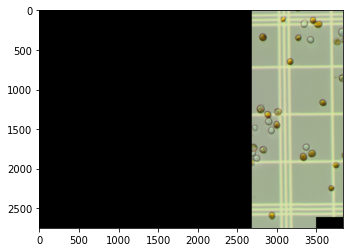

In [ ]:
img = np.array(imgs[0])
mask = get_image_mask(img, Side.Right)
mask = mask.reshape((img.shape[0], img.shape[1], 1))
img[ np.broadcast_to(mask == 0, img.shape) ] = 0

plt.imshow(img)
plt.show()

In [ ]:
###################### TEST DO REPO https://github.com/feature-engineer/microscope_grid_stitcher.git ###############
!git clone "https://github.com/feature-engineer/microscope_grid_stitcher.git"

Cloning into 'microscope_grid_stitcher'...
remote: Enumerating objects: 36, done.
remote: Total 36 (delta 0), reused 0 (delta 0), pack-reused 36
Unpacking objects: 100% (36/36), done.


In [ ]:
!ls

ImRegPOC  microscope_grid_stitcher  sample_data


In [ ]:
def consensus_translation_fit(matches, query_points, train_points, tolerance, min_inleirs):
    best_inliers = []
    for match_idx, k_candidates in enumerate(matches):
        for candidate in k_candidates:
            dxdy = query_points[candidate.queryIdx] - train_points[candidate.trainIdx]
            inliers = []
            for other_match_idx, other_k_candidates in enumerate(matches):
                if other_match_idx == match_idx:
                    continue
                best_candidate = _best_fit_for_translation(dxdy, other_k_candidates, query_points, train_points)
                if np.sum(
                    np.square(query_points[best_candidate.queryIdx] - train_points[best_candidate.trainIdx] - dxdy), 1
                ) < tolerance:
                    inliers.append((query_points[best_candidate.queryIdx] - train_points[best_candidate.trainIdx]))
            if len(inliers) > min_inleirs and len(inliers) > len(best_inliers):
                best_inliers = inliers
    best_inliers = np.row_stack(best_inliers)
    if not best_inliers:
        return None, None
    return np.mean(best_inliers, 0), np.std(best_inliers, 0)


def _best_fit_for_translation(dxdy, k_candidates, query_points, train_points):

    sum = 0

    for candidate in k_candidates:
        sum = sum + np.square(query_points[candidate.queryIdx] - train_points[candidate.trainIdx] - dxdy) 

    return k_candidates[np.argmin(sum)]

In [ ]:
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
import microscope_grid_stitcher.utils

IMAGES_PATH = 'images'
IMAGES_PER_ROW = 5

descriptor_builder = cv2.ORB_create()
# use BFMatcher for binary feature descriptors such as ORB, FLANN for floats
# NORM_HAMMING is the distance used for ORB descriptors
matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING)

for idx, img in enumerate(imgs):
    row = idx // IMAGES_PER_ROW
    col = idx % IMAGES_PER_ROW

    if idx == 0:
        img_height = img.shape[0]
        img_width = img.shape[1]
        prev_img = img[:, int(3 * img_width / 4):, :].copy()
        img_mask = 255 * np.ones(img.shape[:2], dtype=np.uint8)
        img_mask[int(3 * img_height / 4):, int(3 * img_width / 4):] = 0
        continue
    img_points, img_descriptors = descriptor_builder.detectAndCompute(img, img_mask)
    other_img_points, other_img_descriptors = descriptor_builder.detectAndCompute(prev_img, None)
    if row > 0:
        img_above = cv2.imread(image_paths[idx + IMAGES_PER_ROW])[int(3 * img_height / 4), :, :]
        img_above_points, img_above_descriptors = descriptor_builder.detectAndCompute(img_above, None)
        other_img_points.extend(img_above_points)
        other_img_descriptors.extend(img_above_descriptors)
    matches1 = matcher.knnMatch(img_descriptors, other_img_descriptors, 5)
    matches2 = matcher.knnMatch(img_descriptors, other_img_descriptors, 5)
    matches = microscope_grid_stitcher.utils.symmetric_matches_k_matches_per_point(matches1, matches2, 5)
    (dx, dy), (dx_std, dy_std) = consensus_translation_fit(
        matches, cv2.KeyPoint.convert(img_points), cv2.KeyPoint.convert(other_img_points), 9, 20)

    print(f'offest = ({dx}±{dx_std}, {dy}±{dy_std})')

AxisError: ignored

In [ ]:
def get_affine_transform_old(image1, image2):
    image1 = image1[:2641,:]
    image2 = image2[:2641,:]

    orb = cv2.ORB_create(nfeatures = 1000)

    kp1, des1 = orb.detectAndCompute(image1, None)
    kp2, des2 = orb.detectAndCompute(image2, None)

    
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k = 2)
    
    good = []
    for m,n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)

    good = sorted(good, key = lambda x : x.distance)
    
    plt.figure(figsize=(20,20))
    plt.imshow(cv2.drawMatches(image1, kp1, image2, kp2, good[:5], None, flags = 2, matchColor=0))
    plt.show()

    pts1 = np.zeros((5,2), dtype=np.float32)
    pts2 = np.zeros((5,2), dtype=np.float32)

    for i in range(5):
        pts1[i] = kp1[good[i].queryIdx].pt
        pts2[i] = kp2[good[i].trainIdx].pt
    
    return cv2.estimateAffinePartial2D(pts2, pts1)

In [ ]:
from enum import Enum, auto

class Side(Enum):
    Up = auto()
    Down = auto()
    Left = auto()
    Right = auto()
    Label = auto()

class MatchMode(Enum):
    Horizontal = auto()
    Vertical = auto()

def get_image_mask(img, side, margin_tolerance=0.3, mask_label=True):
    labelStartRelative = (2620 / 2758, 3500 / 3840)
    mask = np.zeros(img.shape, dtype=np.uint8)
    if side == Side.Label:
        mask = np.ones(img.shape, dtype=np.uint8)

    if side == Side.Right:
        mask[:, int((1 - margin_tolerance) * mask.shape[1]) : ] = 255
    if side == Side.Left:
        mask[:, : int(margin_tolerance * mask.shape[1]) + 1] = 255
    if side == Side.Up:
        mask[: int(margin_tolerance * mask.shape[0] + 1), :] = 255
    if side == Side.Down:
        mask[int((1 - margin_tolerance) * mask.shape[0]) :, :] = 255

    if side == Side.Label or mask_label:
        mask[int(labelStartRelative[0] * mask.shape[0]):, int(labelStartRelative[1] * mask.shape[1]):] = 0
    
    return mask

In [ ]:
def drawMatches(imageA, imageB, kpsA, kpsB, matches):
    # initialize the output visualization image
    (hA, wA) = imageA.shape[:2]
    (hB, wB) = imageB.shape[:2]
    vis = np.zeros((max(hA, hB), wA + wB), dtype="uint8")
    vis[0:hA, 0:wA] = imageA
    vis[0:hB, wA:] = imageB
    # loop over the matches
    for match in matches:
        trainIdx = match.trainIdx 
        queryIdx = match.queryIdx
        # draw the match
        ptA = (int(kpsA[queryIdx].pt[0]), int(kpsA[queryIdx].pt[1]))
        ptB = (int(kpsB[trainIdx].pt[0]) + wA, int(kpsB[trainIdx].pt[1]))
        cv2.line(vis, ptA, ptB, (255, 0, 0), 5)
    # return the visualization
    return vis

In [ ]:
def get_rigid_transform(image1, image2, direction = MatchMode.Horizontal):
    mask1 = get_image_mask(image1, Side.Right)
    mask2 = get_image_mask(image2, Side.Left)
    
    orb = cv2.ORB_create(nfeatures = 1000)

    kp1, des1 = orb.detectAndCompute(image1, mask1)
    kp2, des2 = orb.detectAndCompute(image2, mask2)
    
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k = 2)
    
    good = []
    for m,n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)

    good = sorted(good, key = lambda x : x.distance)
    
    plt.figure(figsize=(20,20))
    plt.imshow(drawMatches(image1, image2, kp1, kp2, good[:5]))
    plt.show()

    pts1 = np.zeros((5,2), dtype=np.float32)
    pts2 = np.zeros((5,2), dtype=np.float32)

    for i in range(5):
        pts1[i] = kp1[good[i].queryIdx].pt
        pts2[i] = kp2[good[i].trainIdx].pt
    
    return cv2.estimateAffinePartial2D(pts2, pts1)

In [ ]:
def pre_process(img):
    edges = cv2.Canny(img,80,80)

    edges = cv2.blur(edges,(5,5))

    _, edeges = cv2.threshold(edges, 0, 120, cv2.THRESH_BINARY)

    edges[2600:2800, 3500:3900] = 0

    test_img = img.copy()
    test_img[:,:,0] += edges
    test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2GRAY)

    #searching for circles around cells
    circles = cv2.HoughCircles(test_img, 
                    cv2.HOUGH_GRADIENT, 1, 20, param1 = 50,
                param2 = 40, minRadius = 20, maxRadius = 55)
    #removing overlaid circles
    circles_ord = list(circles.copy()[0])

    circles_ord.sort(key=lambda tup: tup[2], reverse=True)

    circles_ord = np.array(circles_ord)

    cells = []

    collided = False
    for circle1 in circles_ord:
        for circle2 in cells:
            dist = np.sqrt( ( circle1[0] - circle2[0])**2 + (circle1[1] - circle2[1])**2 )

            #are they overlapping a lot?
            if dist < circle1[2] + circle2[2] and dist < max(circle1[2], circle2[2]):
                collided = True
                break
        if not collided:
            cells.append(circle1)
        else:
            collided = False

    cimg = np.zeros(img.shape, dtype=np.uint8)

    margin = 5

    for i in cells:
        # draw the outer circle

        top = int(i[0] - i[2] - margin)
        left = int(i[1] - i[2] - margin)

        start_point = (top, left)
        end_point = (int(top+2*(i[2] + margin)), int(left+2*(i[2] + margin)))

        thickness = 2
        color = (0,0,255)
        # cimg = cv2.rectangle(cimg, start_point, end_point, color, thickness)
        cv2.circle(cimg,(i[0],i[1]),int(i[2] + margin),(255,255,255),-1)
        
    return cv2.cvtColor(cv2.bitwise_and(cimg, img), cv2.COLOR_BGR2GRAY)

In [ ]:
def pre_process_cells(img):
    #thresholding
    _, thresh = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 150, 255, cv2.THRESH_BINARY_INV)


    thresh[2600:2800, 3500:3900] = 0
    thresh[thresh > 0] = 215

    #morphological operations to close holes and remove noise
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
    mask_dead = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=5)

    mask = img.copy()

    mask[:,:,0] = thresh
    mask[:,:,1] = thresh
    mask[:,:,2] = thresh
    

    return cv2.bitwise_and(mask, img)

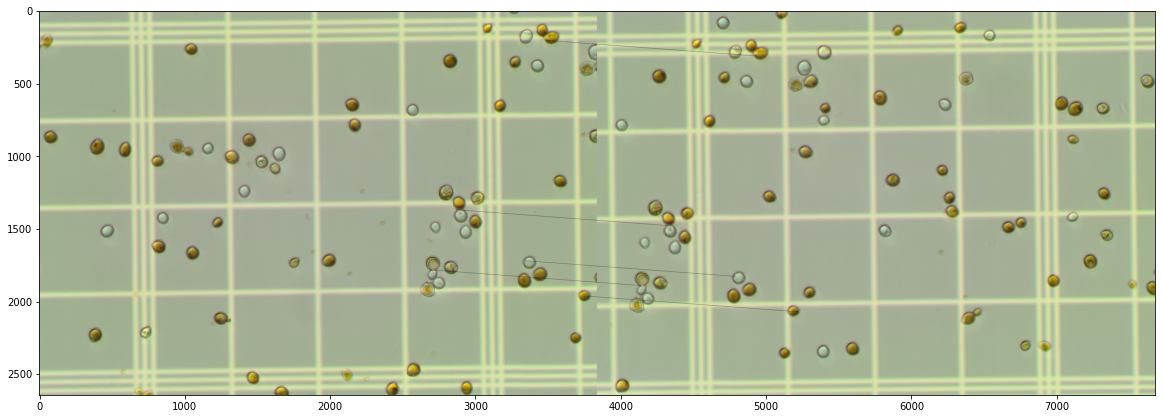

[[ 1.00039734e+00 -2.41219871e-03  2.40125329e+03]
 [ 2.41219871e-03  1.00039734e+00 -1.09939612e+02]]


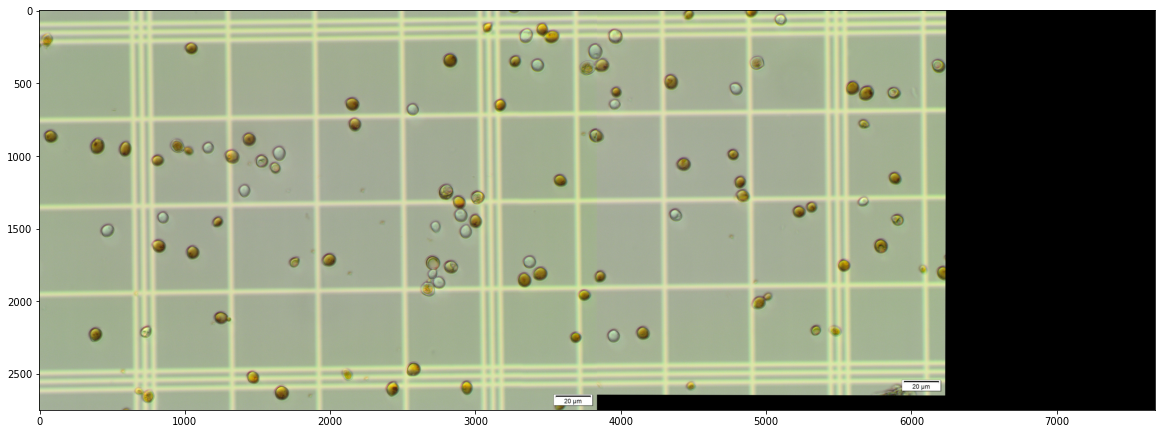

In [ ]:
imageA = imgs[0]
imageB = imgs[1]

M = get_affine_transform_old(imageA, imageB)[0]

print(M)
result = cv2.warpAffine(imageB, M, (imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
result[0:imageA.shape[0], 0:imageA.shape[1]] = imageA

plt.figure(figsize=(20,20))
plt.imshow(result)

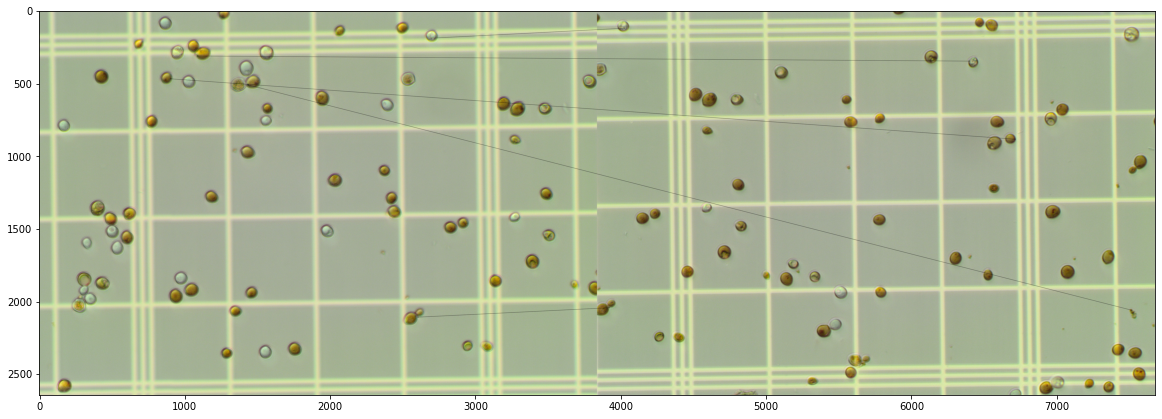

[[-3.11621663e-01  7.16381068e-01  1.17240380e+03]
 [-7.16381068e-01 -3.11621663e-01  2.80156702e+03]]


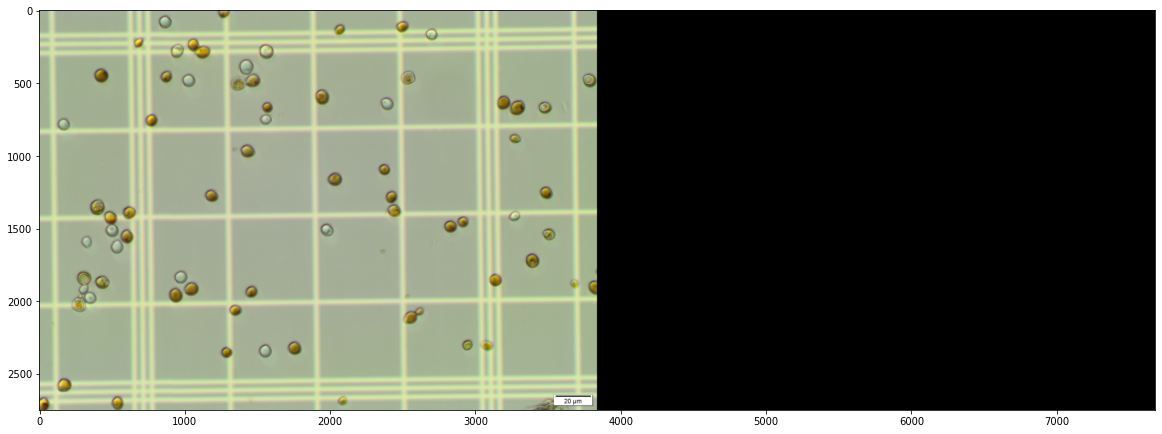

In [ ]:
imageA = imgs[1]
imageB = imgs[2]

M = get_affine_transform_old(imageA, imageB)[0]

print(M)
result = cv2.warpAffine(imageB, M, (imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
result[0:imageA.shape[0], 0:imageA.shape[1]] = imageA

plt.figure(figsize=(20,20))
plt.imshow(result)

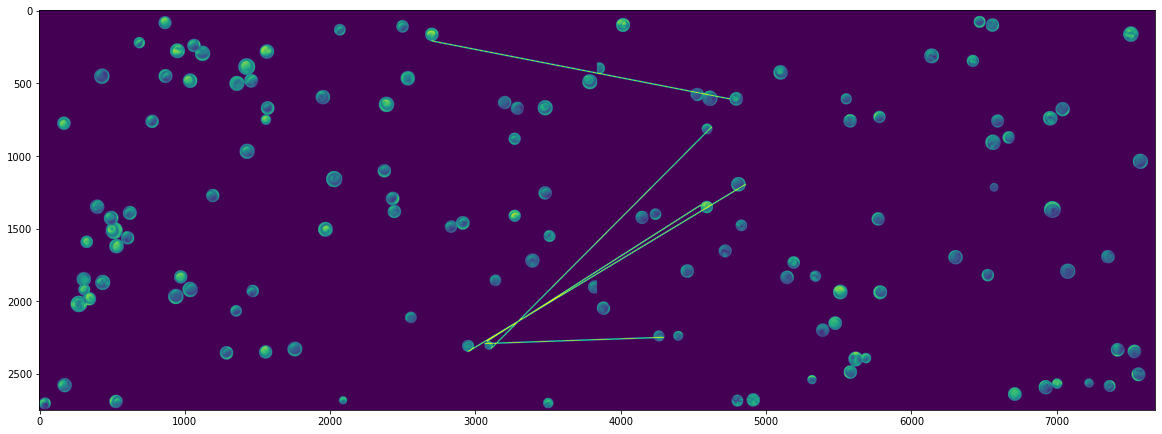

[[ 6.78988164e+00  6.46793005e+00 -7.43480939e+03]
 [-6.46793005e+00  6.78988164e+00  1.96892440e+03]]


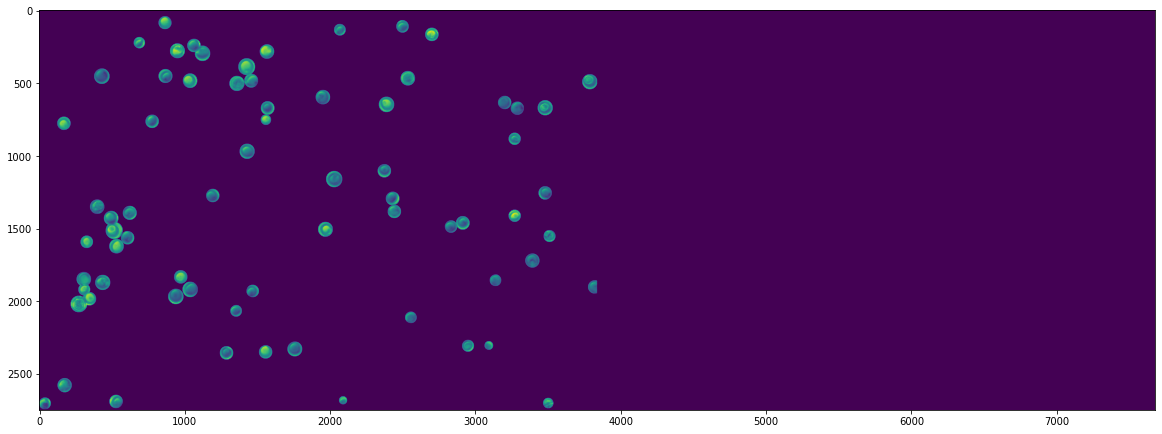

In [ ]:
imageA = pre_process(imgs[1])
imageB = pre_process(imgs[2])



#stitcher = cv2.Stitcher.create(cv2.Stitcher_SCANS)
#stitcher.estimateTransform()

M = get_rigid_transform(imageA, imageB)[0]

print(M)
result = cv2.warpAffine(imageB, M, (imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
result[0:imageA.shape[0], 0:imageA.shape[1]] = imageA

plt.figure(figsize=(20,20))
plt.imshow(result)

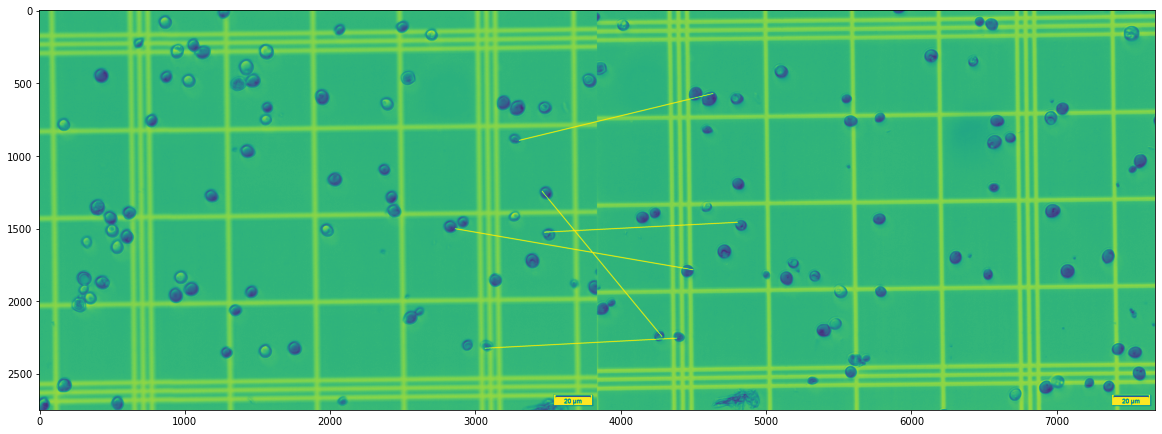

[[ 1.80838010e-01  1.31869895e-01  3.08438901e+03]
 [-1.31869895e-01  1.80838010e-01  8.97489918e+02]]


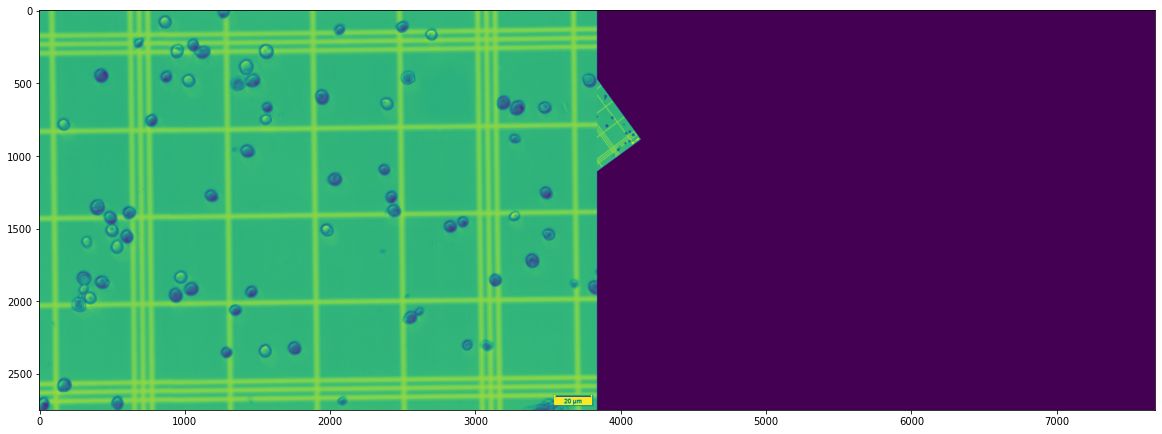

In [ ]:
imageA = cv2.cvtColor(imgs[1], cv2.COLOR_BGR2GRAY)
imageB = cv2.cvtColor(imgs[2], cv2.COLOR_BGR2GRAY)



#stitcher = cv2.Stitcher.create(cv2.Stitcher_SCANS)
#stitcher.estimateTransform()

M = get_rigid_transform(imageA, imageB)[0]

print(M)
result = cv2.warpAffine(imageB, M, (imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
result[0:imageA.shape[0], 0:imageA.shape[1]] = imageA

plt.figure(figsize=(20,20))
plt.imshow(result)